In [1]:
import math
import os
import random
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
 
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from scipy import stats
from sklearn.impute import SimpleImputer
import re
from sklearn.metrics import classification_report, accuracy_score


In [2]:
df = pd.read_csv("../../datasets/titanic.csv")
df.drop(columns=["Cabin"], inplace=True)
#Debo quitar passengerId, de lo contrario generaria un mal modelo
df.drop(columns=["PassengerId"], inplace=True)
df.drop(columns=["Ticket"], inplace=True)
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df[["Embarked"]])
df.loc[:,"Embarked"] = imputer.transform(df[["Embarked"]])
df.loc[:,"FamSize"] = df["SibSp"] + df["Parch"] + 1
df.drop(columns=["SibSp", "Parch"], inplace=True)
df.loc[:, "Age"] = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df[["Age"]])

In [3]:
def get_title(name):
    # letras antes del punto
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

df['Title'] = df['Name'].apply(get_title)
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = df['Title'].replace(['Lady', 'Master', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'No Conocido')

df.drop("Name", inplace=True, axis=1)

In [4]:
#Codigo propio, no es una clase sklearn, veremos el tema mas adelante
#Simplemente remueve outliers
num_cols = df.select_dtypes(include=[np.number]).columns
sys.path.insert(0, '../../Code')
from CustomTransformers import ColOutlierRemover
#Esto no es del todo correcto, pero es un ejemplo
ore = ColOutlierRemover(percent=1.5, strategy="remove", columns=list(num_cols))
ore.fit(df)
df = ore.transform(df)

In [5]:
pred_cols = df.columns[df.columns != "Survived"]
outcome = "Survived"

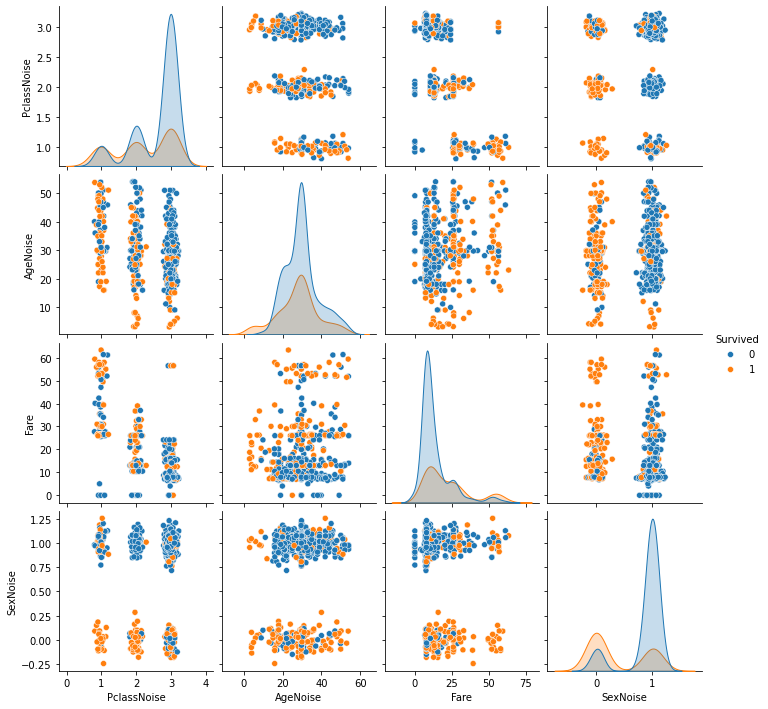

In [6]:
#pongo ruido para identificar mejor los valores
df_t = df.copy()
df_t["Sex"] = df_t["Sex"].map({"male": 1, "female": 0})
df_t["PclassNoise"] = df_t["Pclass"]+np.random.normal(0, 0.08, df.shape[0]) 
df_t["AgeNoise"] = df_t["Age"]+np.random.normal(0, 0.08, df.shape[0])
df_t["SexNoise"] = df_t["Sex"]+np.random.normal(0, 0.08, df.shape[0])
sns.pairplot(df_t[["PclassNoise", "AgeNoise", "Survived", "Fare", "SexNoise"]], hue="Survived")
plt.show()
del df_t

In [7]:
X = df[df.columns[df.columns != "Survived"]]
y = df[outcome]
X_dumm = pd.get_dummies(X, drop_first=True, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size=0.2)
ss = StandardScaler()
ss.fit(X_train)
X_train.loc[:,:] = ss.transform(X_train)
X_test.loc[:,:] = ss.transform(X_test)
#columns  = ["Sex", "Age", "Pclass", "FamSize", "Embarked", "Title", "Fare"]
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
score = knn.score(X_test, y_test)
print(score)

0.8045112781954887
